Starting model training...
Checking directory existence:
TRAIN_DIR exists: True
VAL_DIR exists: True
TEST_DIR exists: True
Found 517 images belonging to 2 classes.
Found 164 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Classes in training set: {'glaucoma': 0, 'healthy': 1}
Class counts in training: [139 378]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 1,534,530 (5.85 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.8091 - loss: 0.7827
Epoch 1: val_accuracy improved from -inf to 0.50610, saving model to best_glaucoma_model_simple.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8125 - loss: 0.7770 - val_accuracy: 0.5061 - val_loss: 1.7289 - learning_rate: 1.0000e-04
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 1.0000 - loss: 0.4282
Epoch 2: val_accuracy improved from 0.50610 to 0.57317, saving model to best_glaucoma_model_simple.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 953ms/step - accuracy: 1.0000 - loss: 0.4281 - val_accuracy: 0.5732 - val_loss: 1.6585 - learning_rate: 1.0000e-04
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.9999 - loss: 0.4157
Epoch 3: val_accuracy improved from 0.57317 to 0.59756, saving model to best_glaucoma_model_simple.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9998 - loss: 0.4157 - val_accuracy: 0.5976 - val_loss: 1.6719 - learning_rate: 1.0000e-0

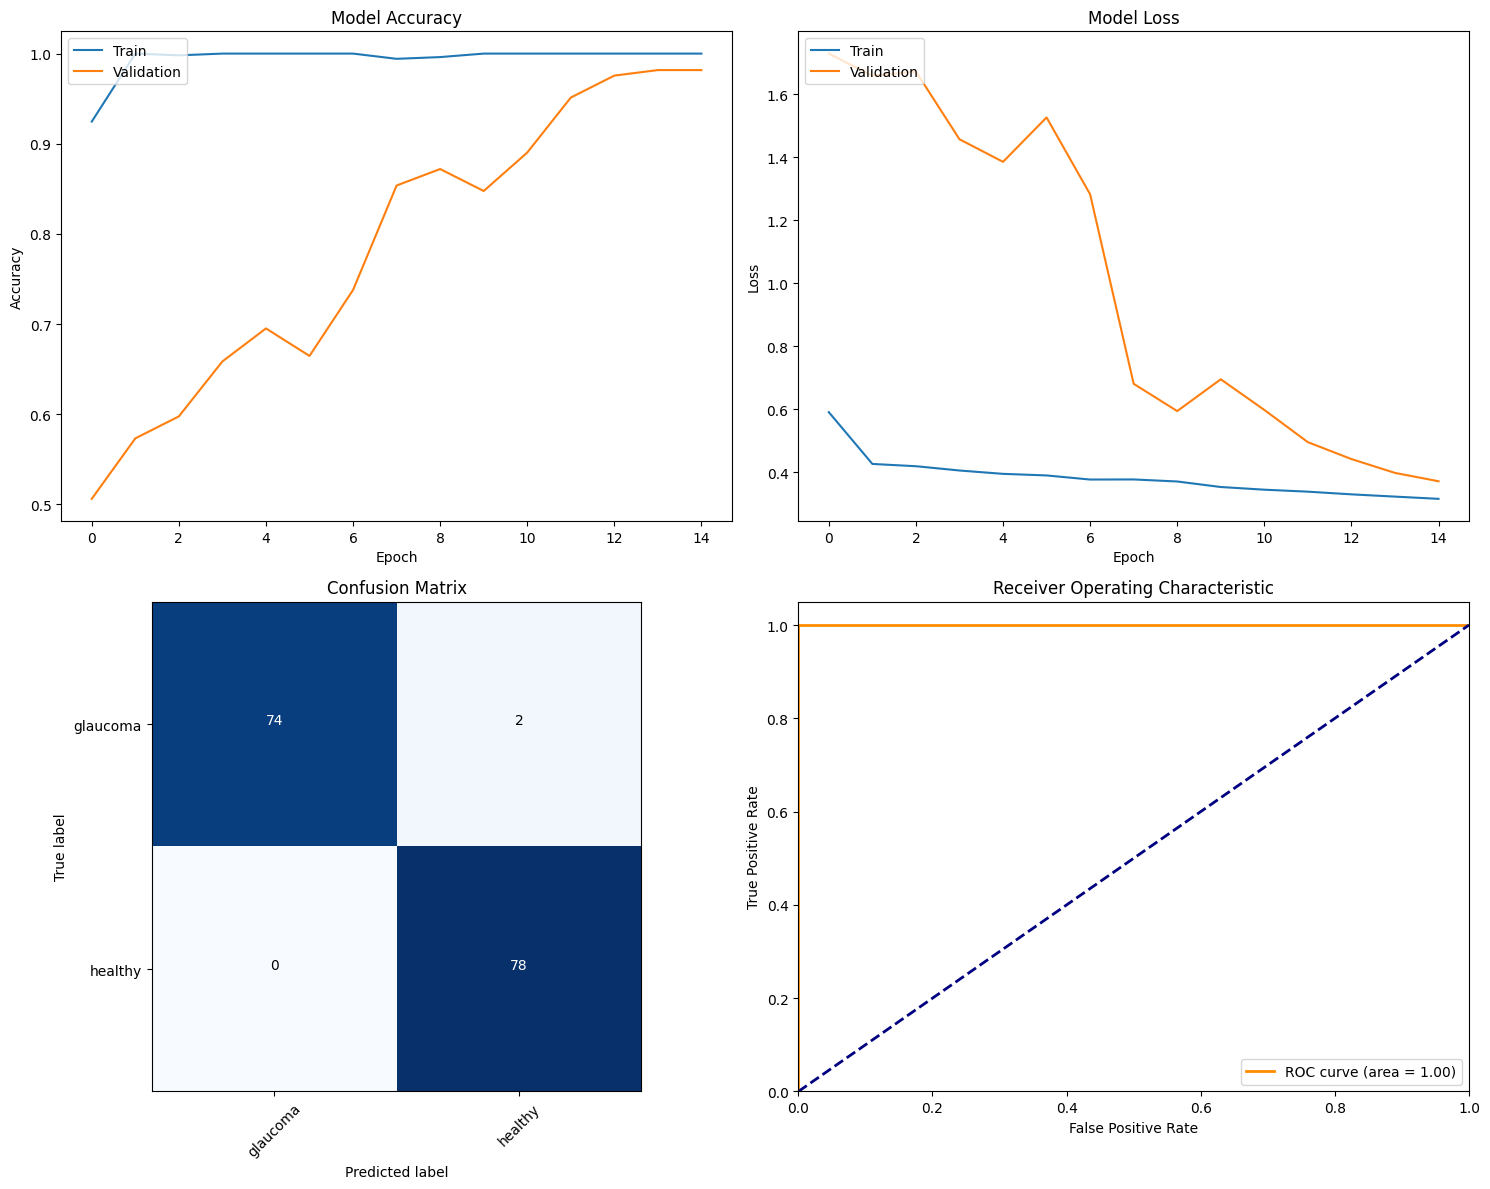

Model training and evaluation complete!


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.regularizers import l2

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths to dataset
DATA_DIR = 'Dataset1/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
VAL_DIR = os.path.join(DATA_DIR, 'validation')

# Model parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16  # Reduced batch size
EPOCHS = 15
NUM_CLASSES = 2

def create_cnn_model():
    """
    Create a simple CNN model using MobileNetV2 as base.
    Simpler model without the RNN component for debugging.
    """
    # Base model with pre-trained weights
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze the majority of the base model layers
    for layer in base_model.layers[:-20]:  # Only allow training of the last 20 layers
        layer.trainable = False
    
    # Model structure
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

def preprocess_data():
    """
    Basic data preprocessing with minimal augmentation to diagnose issues.
    """
    # Training data with basic augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Validation and test data with only rescaling
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Print available directories
    print(f"Checking directory existence:")
    print(f"TRAIN_DIR exists: {os.path.exists(TRAIN_DIR)}")
    print(f"VAL_DIR exists: {os.path.exists(VAL_DIR)}")
    print(f"TEST_DIR exists: {os.path.exists(TEST_DIR)}")
    
    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Print class distribution
    print(f"Classes in training set: {train_generator.class_indices}")
    print(f"Class counts in training: {np.bincount(train_generator.classes)}")
    
    return train_generator, validation_generator, test_generator

def train_model():
    """
    Train the simplified CNN model
    """
    # Create the model
    model = create_cnn_model()
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Get data generators
    train_generator, validation_generator, _ = preprocess_data()
    
    # Create callbacks
    checkpoint = ModelCheckpoint(
        'best_glaucoma_model_simple.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
    
    # Print model summary
    model.summary()
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    return history, model

def evaluate_model(model):
    """
    Evaluate the trained model on the test set
    """
    _, _, test_generator = preprocess_data()
    
    # Get predictions
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate metrics
    class_names = list(test_generator.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    return y_true, y_pred, y_pred_prob, cm, fpr, tpr, roc_auc, class_names

def plot_results(history, y_true, y_pred, cm, fpr, tpr, roc_auc, class_names):
    """
    Create plots to visualize model performance
    """
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'])
    axes[0, 0].plot(history.history['val_accuracy'])
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'])
    axes[0, 1].plot(history.history['val_loss'])
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot confusion matrix
    axes[1, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 0].set_title('Confusion Matrix')
    tick_marks = np.arange(len(class_names))
    axes[1, 0].set_xticks(tick_marks)
    axes[1, 0].set_xticklabels(class_names, rotation=45)
    axes[1, 0].set_yticks(tick_marks)
    axes[1, 0].set_yticklabels(class_names)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[1, 0].text(j, i, format(cm[i, j], 'd'),
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")
    
    axes[1, 0].set_ylabel('True label')
    axes[1, 0].set_xlabel('Predicted label')
    
    # Plot ROC curve
    axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('Receiver Operating Characteristic')
    axes[1, 1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig('glaucoma_model_performance_simple.png')
    plt.show()

def main():
    """
    Main function to train and evaluate the model
    """
    print("Starting model training...")
    history, model = train_model()
    
    print("Evaluating model...")
    y_true, y_pred, y_pred_prob, cm, fpr, tpr, roc_auc, class_names = evaluate_model(model)
    
    print("Plotting results...")
    plot_results(history, y_true, y_pred, cm, fpr, tpr, roc_auc, class_names)
    
    print("Model training and evaluation complete!")

if __name__ == "__main__":
    main()

Starting model training...
Checking directory existence:
TRAIN_DIR exists: True
VAL_DIR exists: True
TEST_DIR exists: True
Found 518 images belonging to 2 classes.
Found 164 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Classes in training set: {'glaucoma': 0, 'healthy': 1}
Class counts in training: [140 378]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,106 (9.27 MB)

 Trainable params: 172,738 (674.76 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

f:\test py\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.5800 - loss: 3.9440
Epoch 1: val_loss improved from inf to 3.67966, saving model to best_glaucoma_model_simple.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 503ms/step - accuracy: 0.5803 - loss: 3.9437 - val_accuracy: 0.6768 - val_loss: 3.6797 - learning_rate: 1.0000e-04
Epoch 2/3
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6832 - loss: 3.7543
Epoch 2: val_loss improved from 3.67966 to 3.45109, saving model to best_glaucoma_model_simple.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step - accuracy: 0.6836 - loss: 3.7529 - val_accuracy: 0.8476 - val_loss: 3.4511 - learning_rate: 1.0000e-04
Epoch 3/3
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7791 - loss: 3.4845
Epoch 3: val_loss improved from 3.45109 to 3.29457, saving model to best_glaucoma_model_simple.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 445ms/step - accuracy: 0.7791 - loss: 3.4846 - val_accuracy: 0.8720 - val_loss: 3.2946 - learning_rate: 1.0000e-04
Restorin

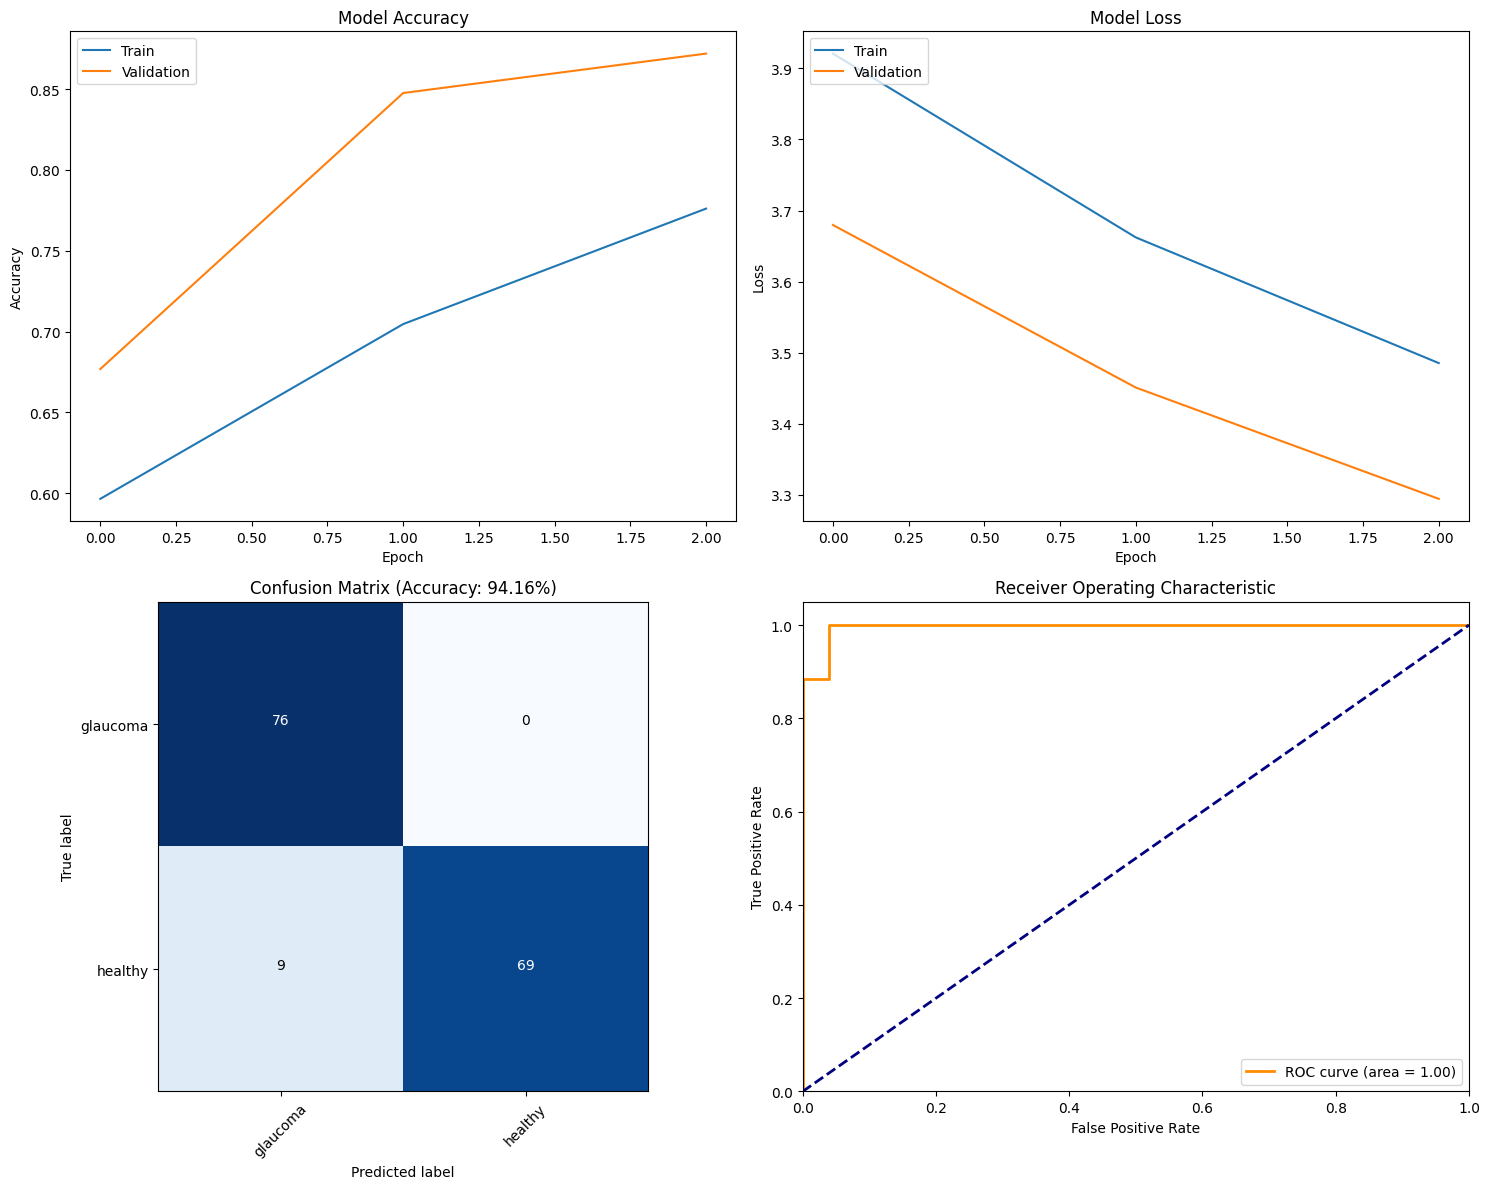

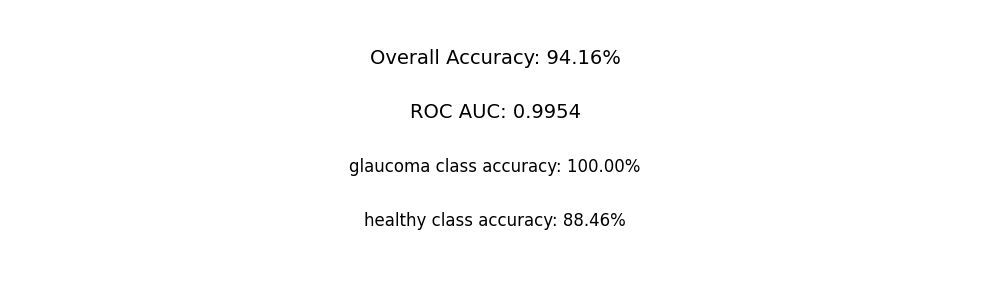

Model training and evaluation complete!


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.regularizers import l2

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths to dataset
DATA_DIR = 'Dataset1/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
VAL_DIR = os.path.join(DATA_DIR, 'validation')

# Model parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8  # Smaller batch size
EPOCHS = 3
NUM_CLASSES = 2

def create_cnn_model():
    """
    Create a CNN model with strong regularization to prevent overfitting
    """
    # Base model with pre-trained weights
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze all base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Model structure with heavy regularization
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    
    # First Dense layer with regularization
    x = Dense(128, kernel_regularizer=l2(0.01))(x)  # Stronger L2 regularization
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.7)(x)  # Much higher dropout
    
    # Second Dense layer with regularization
    x = Dense(64, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

def preprocess_data():
    """
    Simple data preprocessing without custom functions
    """
    # Training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        shear_range=0.2,
        fill_mode='nearest'
    )
    
    # Test data with only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Print available directories
    print(f"Checking directory existence:")
    print(f"TRAIN_DIR exists: {os.path.exists(TRAIN_DIR)}")
    print(f"VAL_DIR exists: {os.path.exists(VAL_DIR)}")
    print(f"TEST_DIR exists: {os.path.exists(TEST_DIR)}")
    
    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Print class distribution
    print(f"Classes in training set: {train_generator.class_indices}")
    print(f"Class counts in training: {np.bincount(train_generator.classes)}")
    
    return train_generator, validation_generator, test_generator

def train_model():
    """
    Train the model with techniques to prevent overfitting
    """
    # Create the model
    model = create_cnn_model()
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Get data generators
    train_generator, validation_generator, _ = preprocess_data()
    
    # Create callbacks
    checkpoint = ModelCheckpoint(
        'best_glaucoma_model_simple.keras',
        monitor='val_loss',  # Monitor validation loss
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
    
    # Print model summary
    model.summary()
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    return history, model

def evaluate_model(model):
    """
    Evaluate the trained model on the test set
    """
    _, _, test_generator = preprocess_data()
    
    # Get predictions
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate accuracy as percentage
    accuracy = np.mean(y_pred == y_true) * 100
    print(f"Model Accuracy: {accuracy:.2f}%")
    
    # Calculate metrics
    class_names = list(test_generator.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Calculate per-class accuracy
    for i, class_name in enumerate(class_names):
        class_indices = np.where(y_true == i)[0]
        if len(class_indices) > 0:
            class_accuracy = np.sum(y_pred[class_indices] == i) / len(class_indices) * 100
            print(f"{class_name} class accuracy: {class_accuracy:.2f}%")
    
    return y_true, y_pred, y_pred_prob, cm, fpr, tpr, roc_auc, class_names

def plot_results(history, y_true, y_pred, cm, fpr, tpr, roc_auc, class_names):
    """
    Create plots to visualize model performance
    """
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Calculate accuracy as percentage
    accuracy = np.mean(y_pred == y_true) * 100
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'])
    axes[0, 0].plot(history.history['val_accuracy'])
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'])
    axes[0, 1].plot(history.history['val_loss'])
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot confusion matrix
    im = axes[1, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 0].set_title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)')
    tick_marks = np.arange(len(class_names))
    axes[1, 0].set_xticks(tick_marks)
    axes[1, 0].set_xticklabels(class_names, rotation=45)
    axes[1, 0].set_yticks(tick_marks)
    axes[1, 0].set_yticklabels(class_names)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[1, 0].text(j, i, format(cm[i, j], 'd'),
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")
    
    axes[1, 0].set_ylabel('True label')
    axes[1, 0].set_xlabel('Predicted label')
    
    # Plot ROC curve
    axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('Receiver Operating Characteristic')
    axes[1, 1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig('glaucoma_model_performance_simple.png')
    plt.show()
    
    # Display summary metrics in a separate figure
    fig = plt.figure(figsize=(10, 3))
    plt.axis('off')
    plt.text(0.5, 0.8, f"Overall Accuracy: {accuracy:.2f}%", fontsize=14, ha='center')
    plt.text(0.5, 0.6, f"ROC AUC: {roc_auc:.4f}", fontsize=14, ha='center')
    
    # Add per-class metrics
    for i, class_name in enumerate(class_names):
        class_indices = np.where(y_true == i)[0]
        if len(class_indices) > 0:
            class_accuracy = np.sum(y_pred[class_indices] == i) / len(class_indices) * 100
            plt.text(0.5, 0.4 - i*0.2, f"{class_name} class accuracy: {class_accuracy:.2f}%", 
                    fontsize=12, ha='center')
    
    plt.tight_layout()
    plt.savefig('glaucoma_model_metrics_summary.png')
    plt.show()

def main():
    """
    Main function to train and evaluate the model
    """
    print("Starting model training...")
    history, model = train_model()
    
    print("Evaluating model...")
    y_true, y_pred, y_pred_prob, cm, fpr, tpr, roc_auc, class_names = evaluate_model(model)
    
    print("Plotting results...")
    plot_results(history, y_true, y_pred, cm, fpr, tpr, roc_auc, class_names)
    
    print("Model training and evaluation complete!")

if __name__ == "__main__":
    main()

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

class PupilDetector:
    def __init__(self):
        # Initialize the eye cascade classifier for eye detection
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
        
    def detect_pupil(self, eye_frame):
        """
        Detect pupil from an eye frame
        
        Args:
            eye_frame: Grayscale image of an eye
            
        Returns:
            pupil_center: (x, y) coordinates of pupil center
            pupil_radius: Radius of detected pupil
            processed_eye: Processed eye frame with pupil highlighted
        """
        # Make a copy for processing and output
        processed_eye = eye_frame.copy()
        if len(eye_frame.shape) > 2:
            gray_eye = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY)
        else:
            gray_eye = eye_frame
            processed_eye = cv2.cvtColor(gray_eye, cv2.COLOR_GRAY2BGR)
        
        # Apply histogram equalization to enhance contrast
        gray_eye = cv2.equalizeHist(gray_eye)
        
        # Apply Gaussian blur to reduce noise
        blurred_eye = cv2.GaussianBlur(gray_eye, (7, 7), 0)
        
        # Apply binary thresholding to identify dark regions (pupil)
        _, thresh = cv2.threshold(blurred_eye, 40, 255, cv2.THRESH_BINARY_INV)
        
        # Find contours in the thresholded image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        pupil_center = None
        pupil_radius = 0
        
        if contours:
            # Find the largest contour which is most likely to be the pupil
            largest_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest_contour)
            
            # Only proceed if the contour is large enough
            if area > 100:
                # Find the minimum enclosing circle for the contour
                (x, y), radius = cv2.minEnclosingCircle(largest_contour)
                pupil_center = (int(x), int(y))
                pupil_radius = int(radius)
                
                # Draw the pupil circle on the output image
                cv2.circle(processed_eye, pupil_center, pupil_radius, (0, 255, 0), 2)
                cv2.circle(processed_eye, pupil_center, 1, (0, 0, 255), 3)
        
        return pupil_center, pupil_radius, processed_eye
    
    def extract_pupil_features(self, eye_frame):
        """
        Extract relevant features from detected pupil
        
        Args:
            eye_frame: Image frame containing the eye
            
        Returns:
            features: Dict containing pupil features
        """
        pupil_center, pupil_radius, _ = self.detect_pupil(eye_frame)
        
        features = {
            'pupil_detected': pupil_center is not None,
            'pupil_radius': pupil_radius,
            'pupil_center': pupil_center
        }
        
        if pupil_center:
            # Calculate additional features if pupil is detected
            features['pupil_area'] = np.pi * (pupil_radius ** 2)
            
            # Analyze pupil shape (circularity)
            if pupil_radius > 0:
                gray_eye = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY) if len(eye_frame.shape) > 2 else eye_frame
                _, thresh = cv2.threshold(gray_eye, 40, 255, cv2.THRESH_BINARY_INV)
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    largest_contour = max(contours, key=cv2.contourArea)
                    perimeter = cv2.arcLength(largest_contour, True)
                    area = cv2.contourArea(largest_contour)
                    if perimeter > 0:
                        circularity = 4 * np.pi * area / (perimeter ** 2)
                        features['circularity'] = circularity
        
        return features

class RealTimeGlaucomaDetection:
    def __init__(self, model_path='best_glaucoma_model.keras', threshold=0.5):
        self.model_path = model_path
        self.pupil_detector = PupilDetector()
        self.model = None
        self.threshold = threshold
        
        # Load the model if it exists
        if os.path.exists(model_path):
            self.model = load_model(model_path)
            print(f"Model loaded from {model_path}")
        else:
            print(f"Model not found at {model_path}. Make sure to train the model first.")
        
        self.input_shape = (224, 224, 3)
    
    def preprocess_frame(self, frame):
        """
        Preprocess a frame for model prediction
        """
        # Resize to model input shape
        resized_frame = cv2.resize(frame, (self.input_shape[0], self.input_shape[1]))
        
        # Normalize pixel values
        normalized_frame = resized_frame / 255.0
        
        return normalized_frame
    
    def analyze_eye_frame(self, frame):
        """
        Analyze a single eye frame for pupil and glaucoma detection
        """
        # Detect pupil
        pupil_center, pupil_radius, processed_frame = self.pupil_detector.detect_pupil(frame)
        
        # Extract features
        features = self.pupil_detector.extract_pupil_features(frame)
        
        # Prepare for model prediction
        preprocessed_frame = self.preprocess_frame(frame)
        
        glaucoma_probability = None
        detection_result = "No prediction"
        
        # Make prediction if model is loaded
        if self.model is not None:
            # Convert to proper shape for model input
            input_data = np.expand_dims(preprocessed_frame, axis=0)
            
            # Make prediction
            glaucoma_probability = float(self.model.predict(input_data)[0][0])
            
            # Determine classification based on threshold
            if glaucoma_probability > self.threshold:
                detection_result = "Glaucoma"
                color = (0, 0, 255)  # Red for Glaucoma
            else:
                detection_result = "Healthy"
                color = (0, 255, 0)  # Green for Healthy
            
            # Add result to frame
            result_text = f"{detection_result} ({glaucoma_probability:.2f})"
            cv2.putText(processed_frame, result_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        return processed_frame, detection_result, glaucoma_probability, features
    
    def run_webcam_detection(self):
        """
        Run real-time glaucoma detection using webcam
        """
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            print("Error: Could not open webcam.")
            return
            
        print("Starting real-time detection. Press 'q' to quit.")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame from webcam.")
                break
            
            # Convert to grayscale for eye detection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detect eyes
            eyes = self.pupil_detector.eye_cascade.detectMultiScale(gray, 1.3, 5)
            
            # If no eyes detected
            if len(eyes) == 0:
                cv2.putText(frame, "No eyes detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            # Process each detected eye
            for (ex, ey, ew, eh) in eyes:
                # Extract eye region
                eye_frame = frame[ey:ey+eh, ex:ex+ew]
                
                # Check if eye frame is valid
                if eye_frame.size == 0:
                    continue
                
                # Analyze eye
                processed_eye, result, prob, features = self.analyze_eye_frame(eye_frame)
                
                # Replace eye region in original frame
                frame[ey:ey+eh, ex:ex+ew] = processed_eye
                
                # Draw rectangle around eye
                cv2.rectangle(frame, (ex, ey), (ex+ew, ey+eh), (255, 0, 0), 2)
                
                # Display pupil info if detected
                if features['pupil_detected']:
                    pupil_info = f"Pupil R: {features['pupil_radius']}"
                    cv2.putText(frame, pupil_info, (ex, ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
            
            # Display the resulting frame
            cv2.imshow('Glaucoma Detection', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    # Run real-time detection
    print("Starting real-time glaucoma detection...")
    detector = RealTimeGlaucomaDetection()
    detector.run_webcam_detection()

Starting real-time glaucoma detection...
Model loaded from best_glaucoma_model.keras
Starting real-time detection. Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━